## Detección de Malaria en Imágenes de Células Sanguíneas Utilizando Redes Neuronales Convolucionales

# Objetivos del proyecto
**Objetivo General:** Desarrollar un modelo de red neuronal convolucional (CNN) para la clasificación de imágenes de células sanguíneas en dos categorías: parasitadas y no infectadas, utilizando el dataset de malaria disponible.

# Objetivos Específicos:

Preprocesamiento de Datos: Preparar el dataset de imágenes de células,

1.   Preparar el dataset de  imágenes de células, realizando las transformaciones necesarias como la normalización y el aumento de datos para mejorar el desempeño del modelo.
2.   Implementar y entrenar una red neuronal convolucional con el objetivo de clasificar correctamente las imágenes en las dos categorías (parasitadas y no infectadas)
3. Evaluar el rendimiento del modelo utilizando métricas como precisión, recall y F1-score en un conjunto de datos de prueba, para garantizar la efectividad del modelo en la clasificación de imágenes de células sanguíneas.
4. Ajustar los parámetros del modelo, como la tasa de aprendizaje y el tamaño de los lotes, con el fin de maximizar la precisión del modelo sin sobreajustarlo.

# Importar Librerias

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


# Cargar el dataset

El dataset de malaria contiene un total de **27,558** imágenes de células sanguíneas, divididas en dos categorías: **células parasitadas y células no infectadas.** Las imágenes están almacenadas en formato TFRecord, un formato eficiente y adecuado para el entrenamiento de modelos de aprendizaje profundo.

Las imágenes presentan tamaños variables, por lo que se requiere un proceso de preprocesamiento de las imagenes para redimensionarlas a un tamaño estándar para asegurar la consistencia en el modelo.

En cuanto a la distribución de clases, el dataset está balanceado, lo que significa que cuenta con un número igual de imágenes parasitadas y no infectadas, lo cual es beneficioso para entrenar un modelo sin sesgo hacia ninguna de las clases.

In [ ]:
# Cargar el dataset Malaria
dataset, ds_info = tfds.load('malaria', as_supervised=True, with_info=True)

# Verificar la estructura del dataset
print(ds_info)


tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir='/root/tensorflow_datasets/malaria/1.0.0',
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thin blood smear im

# Preprocesar los datos

Para preparar el dataset de malaria, se realiza un proceso de preprocesamiento de imágenes. Este paso se requiere para asegurar que los datos sean consistentes y adecuados para el modelo. En primer lugar, las imágenes se redimensionan a un tamaño estándar de 128x128 píxeles, lo que permite que todas las imágenes tengan las mismas dimensiones y facilita su procesamiento en lotes. Luego, las imágenes son normalizadas dividiendo los valores de los píxeles por 255, lo cual ajusta los valores de los píxeles dentro de un rango de 0 a 1, mejorando la estabilidad y la convergencia del modelo durante el entrenamiento.

Además, el dataset de entrenamiento y validación se divide en lotes de tamaño 32 y se utiliza el método prefetch para optimizar la carga de datos y mejorar la eficiencia del entrenamiento, lo que permite que el modelo se entrene de manera más rápida y fluida.

In [ ]:
# Dividir el dataset en conjuntos de entrenamiento y prueba
train_dataset = dataset['train'].take(22000)  # 80% de datos para entrenamiento
val_dataset = dataset['train'].skip(22000).take(3000)  # 10% para validación
test_dataset = dataset['train'].skip(25000)  # 10% restante para prueba

In [ ]:
# Función de preprocesamiento
def preprocess_image(image, label):
    image = tf.image.resize(image, [128, 128])  # Redimensionar imágenes
    image = image / 255.0  # Normalizar imágenes
    return image, label

# Preprocesar los datasets
train_dataset = train_dataset.map(preprocess_image).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.map(preprocess_image).batch(32).prefetch(tf.data.AUTOTUNE)


# Análisis exploratorio de los datos
El análisis exploratorio de datos (EDA) es fundamental para comprender las características del dataset, incluyendo la visualización de las imágenes, el cálculo de estadísticas clave y el análisis de la distribución de clases. Este proceso permite obtener una visión más clara sobre la naturaleza de los datos, lo que facilita la identificación de patrones, posibles sesgos y aspectos importantes que deben ser considerados durante el preprocesamiento. Al realizar un análisis exhaustivo, se establece una base sólida para preparar adecuadamente los datos antes de entrenar el modelo, asegurando que se optimicen las etapas de preparación y entrenamiento

# Visualización del Dataset

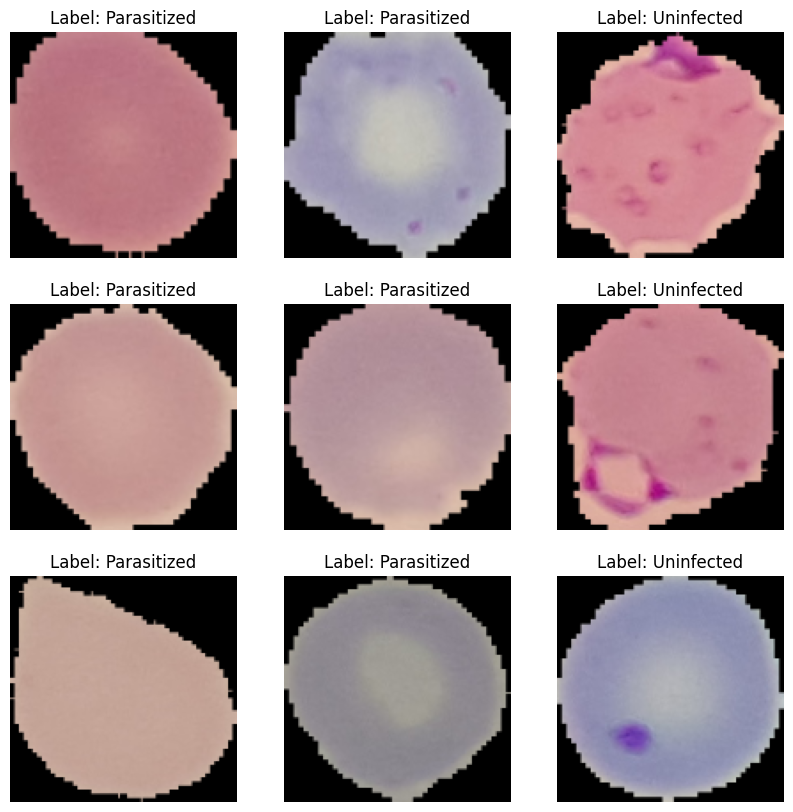

In [ ]:
# Visualización de algunas imágenes del dataset
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f"Label: {'Parasitized' if labels[i] == 1 else 'Uninfected'}")
        plt.axis('off')
plt.show()


In [ ]:
# Imprimir las formas para comprobar
for images, labels in train_dataset.take(1):
    print("Forma de las imágenes:", images.shape)  # Debe imprimir (batch_size, 128, 128, 3)
    print("Forma de las etiquetas:", labels.shape)  # Debe imprimir (batch_size,)

Forma de las imágenes: (32, 128, 128, 3)
Forma de las etiquetas: (32,)


In [ ]:
import tensorflow as tf
import numpy as np

# Calcular media y desviación estándar de las imágenes
def compute_image_statistics(dataset):
    images = dataset.map(lambda image, _: tf.cast(image, tf.float32))
    # Change initial value type to float32 to match the type of tf.reduce_mean output
    mean = images.reduce(np.zeros(3, dtype=np.float32), lambda x, img: x + tf.reduce_mean(img, axis=(0, 1)))
    mean /= len(dataset)
    print(f"Media de los píxeles: {mean.numpy()}")

compute_image_statistics(dataset['train'])

Media de los píxeles: [135.0224  108.09588 115.51971]


A continuzación, se realiza un análisis de la distribución de clases en el dataset de malaria, el objetivo principal es visualizar cuántas imágenes pertenecen a cada clase (parasitadas y no infectadas) para entender mejor el equilibrio del dataset.

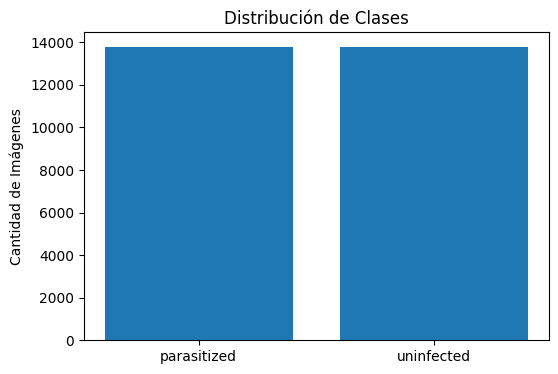

In [ ]:
import tensorflow_datasets as tfds # Assuming your dataset is from tfds
import matplotlib.pyplot as plt

# Assuming 'dataset' is your loaded dataset
# Replace 'your_dataset_name' with the actual name of your dataset
dataset, info = tfds.load('malaria', with_info=True)

# Calculate distribution of classes. Assumes 'label' is a feature
label_counts = dataset['train'].reduce(tf.constant([0, 0], dtype=tf.int64),
                                     lambda x, example: x + tf.one_hot(example['label'], depth=2, dtype=tf.int64))

# Distribution of the classes
label_names = info.features['label'].names
plt.figure(figsize=(6, 4))
plt.bar(label_names, label_counts.numpy())
plt.title('Distribución de Clases')
plt.ylabel('Cantidad de Imágenes')
plt.show()

# Crear la red neuronal convolucional

Para entrenar el modelo se crea una red neuronal convolucional usando la API Sequential de Keras, la cual es útil para construir modelos capa por capa. El objetivo de esta CNN es identificar si una célula está parasitada o no en imágenes de células sanguíneas.


# 1. Capa de Entrada y Primera Capa Convolucional:

layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)):

* Conv2D: Es la primera capa convolucional que aplica 32 filtros a la imagen de entrada.
* Tamaño del filtro: (3, 3), lo que significa que se utiliza una ventana de 3x3 píxeles para cada filtro.
*Función de activación: relu (Rectified Linear Unit), que convierte los valores negativos a 0 y mantiene los positivos. Es una activación común para introducir no linealidad.
*input_shape: La imagen de entrada tiene un tamaño de 128x128 píxeles con 3 canales de color (RGB).

#2.  Primera Capa de Max Pooling:

layers.MaxPooling2D((2, 2)):
* MaxPooling2D: Reduce la dimensión de las características al seleccionar el valor máximo en una ventana de 2x2 píxeles. Esto ayuda a disminuir la cantidad de parámetros, reduciendo el tamaño de la imagen y resaltando las características más importantes.

# 3. Segunda Capa Convolucional:

layers.Conv2D(64, (3, 3), activation='relu'):
* Conv2D: Segunda capa convolucional, esta vez con 64 filtros.
* Tamaño del filtro: (3, 3).
* Función de activación: relu.

#4. Segunda Capa de Max Pooling:

layers.MaxPooling2D((2, 2)):Otra capa de MaxPooling2D con una ventana de 2x2 para reducir aún más la dimensionalidad de la imagen.

#5. Tercera Capa Convolucional:

layers.Conv2D(64, (3, 3), activation='relu'):
* Conv2D: Tercera capa convolucional con 64 filtros adicionales.
* Tamaño del filtro: (3, 3).
* Función de activación: relu.
* Capa de Aplanamiento (Flatten):

# 6. layers.Flatten():
La capa Flatten convierte la salida tridimensional de la última capa convolucional en un vector unidimensional para poder conectar con las capas completamente conectadas (densas).

#7. Primera Capa Densa (Fully Connected):

layers.Dense(64, activation='relu'):
* Dense: Capa totalmente conectada con 64 unidades.
*Función de activación: relu.
#8. Capa de Salida:

layers.Dense(2, activation='softmax'):
*Dense: Capa de salida con 2 unidades, una para cada clase (parasitada y no infectada).
*Función de activación: softmax, que convierte los valores de salida en probabilidades, sumando 1 en total. Se utiliza para problemas de clasificación multiclase o binaria cuando las etiquetas son mutuamente excluyentes.

In [ ]:

# Crear la red neuronal convolucional
model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(2, activation='softmax')  # 2 clases: Parasitized y Uninfected
])

# Compilar el modelo
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Resumen del modelo
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 28, 28, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 64)                  │       3,211,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,267,778 (12.47 MB)

 Trainable params: 3,267,778 (12.47 MB)

 Non-trainable params: 0 (0.00 B)

# Entrenar el modelo

In [ ]:
# Entrenar el modelo
model.fit(train_dataset, epochs=10, validation_data=val_dataset)


Epoch 1/10
688/688 ━━━━━━━━━━━━━━━━━━━━ 44s 62ms/step - accuracy: 0.7261 - loss: 0.5108 - val_accuracy: 0.9277 - val_loss: 0.1835
Epoch 2/10
688/688 ━━━━━━━━━━━━━━━━━━━━ 72s 48ms/step - accuracy: 0.9363 - loss: 0.1746 - val_accuracy: 0.9477 - val_loss: 0.1702
Epoch 3/10
688/688 ━━━━━━━━━━━━━━━━━━━━ 49s 60ms/step - accuracy: 0.9536 - loss: 0.1390 - val_accuracy: 0.9497 - val_loss: 0.1609
Epoch 4/10
688/688 ━━━━━━━━━━━━━━━━━━━━ 74s 48ms/step - accuracy: 0.9605 - loss: 0.1161 - val_accuracy: 0.9517 - val_loss: 0.1822
Epoch 5/10
688/688 ━━━━━━━━━━━━━━━━━━━━ 36s 52ms/step - accuracy: 0.9693 - loss: 0.0892 - val_accuracy: 0.9563 - val_loss: 0.1908
Epoch 6/10
688/688 ━━━━━━━━━━━━━━━━━━━━ 33s 48ms/step - accuracy: 0.9757 - loss: 0.0715 - val_accuracy: 0.9510 - val_loss: 0.2083
Epoch 7/10
688/688 ━━━━━━━━━━━━━━━━━━━━ 42s 49ms/step - accuracy: 0.9839 - loss: 0.0477 - val_accuracy: 0.9480 - val_loss: 0.2552
Epoch 8/10
688/688 ━━━━━━━━━━━━━━━━━━━━ 34s 49ms/step - accuracy: 0.9885 - loss: 0.0341 - 

# Guardar el modelo

In [ ]:
# Guardar el modelo
model.save('malaria_cnn_model.keras')


# Realizar predicciones con imágenes

80/80 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step


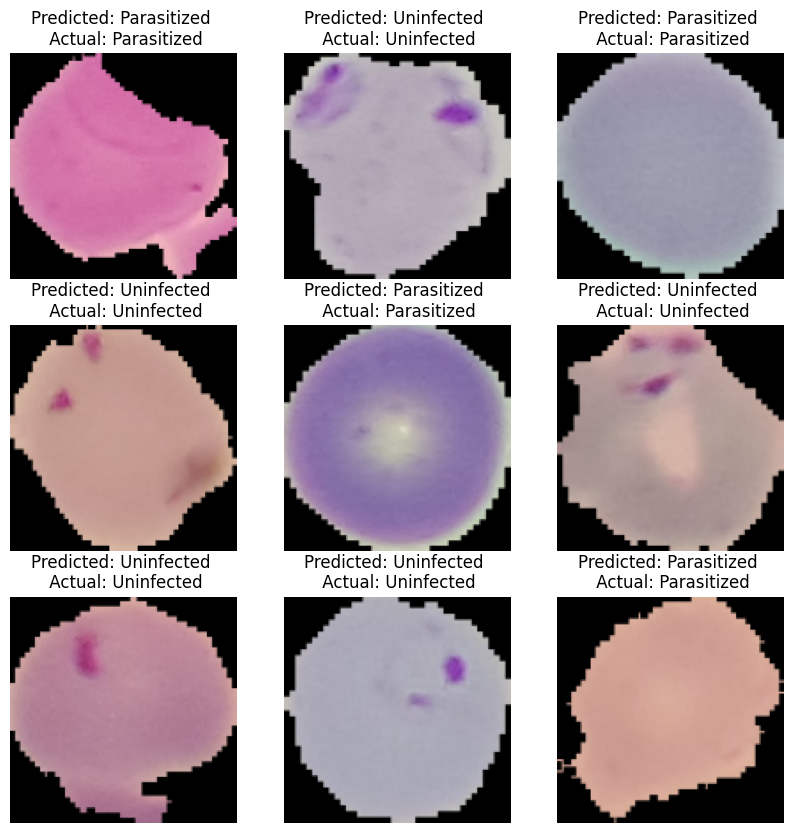

In [ ]:
# Cargar el modelo
model = keras.models.load_model('malaria_cnn_model.keras')

# Ajustar el tamaño de las imágenes en el conjunto de prueba
test_dataset = test_dataset.map(lambda image, label: (tf.image.resize(image, [128, 128]), label))
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Hacer predicciones sobre un pequeño conjunto de imágenes
predictions = model.predict(test_dataset)

# Visualizar algunas predicciones
plt.figure(figsize=(10, 10))
for images, labels in test_dataset.take(1):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        pred_label = "Parasitized" if np.argmax(predictions[i]) == 1 else "Uninfected"
        true_label = "Parasitized" if labels[i] == 1 else "Uninfected"
        plt.title(f"Predicted: {pred_label} \n Actual: {true_label}")
        plt.axis('off')
plt.show()


# Realizar métricas de evaluación

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━

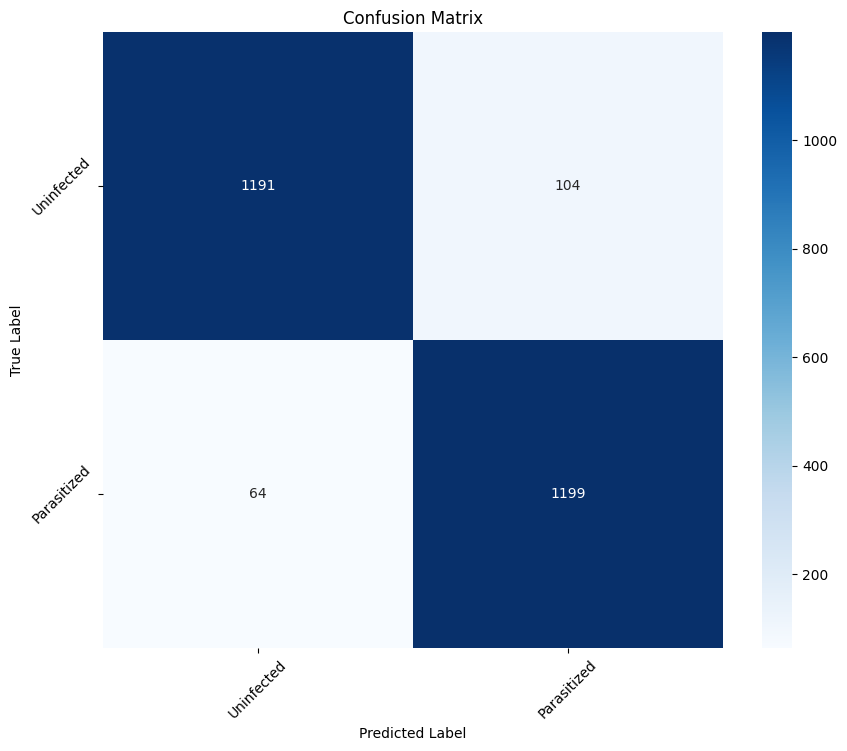

In [ ]:
# Calcular la matriz de confusión
y_true = []
y_pred = []

for images, labels in test_dataset:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Visualizar la matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(ticks=[0.5, 1.5], labels=['Uninfected', 'Parasitized'], rotation=45)
plt.yticks(ticks=[0.5, 1.5], labels=['Uninfected', 'Parasitized'], rotation=45)
plt.show()

#Reporte de Clasificación

El reporte de clasificacion permite evaluar el rendimiento del modelo de clasificación. Proporciona métricas clave como precisión, recall, f1-score y support para cada clase, ayudando a entender cómo el modelo predice cada categoría. A continuación, se presenta el análisi del reporte2.:

1. **Precisión Global:** El modelo alcanza una precisión del 91% tras entrenarse durante 10 épocas, lo que indica que clasifica correctamente la gran mayoría de las imágenes en el conjunto de prueba. Esto refleja que el modelo ha logrado aprender de manera efectiva las características distintivas de las imágenes para diferenciar entre células parasitadas y no infectadas.

2. **Rendimiento por Clases:**

+ **Células No Infectadas:**Precisión del 90%: De todas las predicciones de células no infectadas, el 90% son correctas.
Sensibilidad del 93%: El modelo detecta la gran mayoría de las células no infectadas.
F1-Score del 91%, mostrando un buen equilibrio entre precisión y recall.
* **Células Parasitadas:**
Precisión del 93%: Alta capacidad para identificar correctamente las células parasitadas.
Sensibilidad del 89%: El modelo detecta la mayoría de las células parasitadas, aunque podría mejorarse un poco para reducir falsos negativos.
F1-Score también del 91%, lo que indica una capacidad consistente en la clasificación de esta clase.
Consistencia del Modelo: Tanto el promedio simple (macro avg) como el promedio ponderado (weighted avg) para precisión, recall y F1-Score son del 91%, lo que sugiere que el modelo trata a ambas clases de manera equitativa y no muestra sesgo hacia ninguna categoría.

In [ ]:
from sklearn.metrics import classification_report

# Assuming you have y_true (true labels) and y_pred (predicted labels)
# from your previous code...

# Generate the classification report
report = classification_report(y_true, y_pred, target_names=['Uninfected', 'Parasitized'])

# Print the report
print(report)

              precision    recall  f1-score   support

  Uninfected       0.95      0.92      0.93      1295
 Parasitized       0.92      0.95      0.93      1263

    accuracy                           0.93      2558
   macro avg       0.93      0.93      0.93      2558
weighted avg       0.93      0.93      0.93      2558



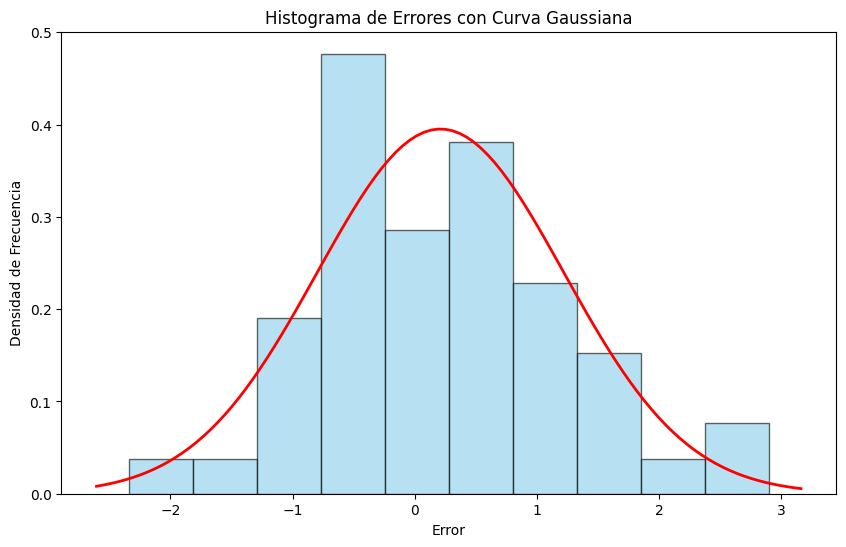

In [ ]:
# Instalar las librerías necesarias
!pip install pandas
!pip install tensorflow
!pip install scipy

# Importar las librerías necesarias
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from scipy.stats import norm

# Supongamos que tienes un modelo entrenado y quieres calcular los errores
# Ejemplo: Generar una lista de errores basada en las predicciones de un modelo
# Asumiendo que ya tienes un modelo entrenado y datos de prueba (X_test, y_test)

# Ejemplo de cómo calcular los errores (esto puede variar según tu contexto)
# X_test, y_test deben estar definidos con tus datos de prueba
# predictions = model.predict(X_test)
# errors = y_test - predictions  # Calcular errores (esto es un ejemplo)

# Para propósitos de ejemplo, aquí generamos algunos valores aleatorios para 'errors'
errors = np.random.randn(100)  # Generar 100 errores aleatorios

# 6. Graficar el histograma de errores
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=10, edgecolor='black', density=True, alpha=0.6, color='skyblue')  # Normalizado para que se ajuste a la curva gaussiana

# Calcular la media y desviación estándar de los errores
mean = np.mean(errors)
std_dev = np.std(errors)

# Generar valores para la curva gaussiana
xmin, xmax = plt.xlim()  # Límites del eje x para la gráfica
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mean, std_dev)

# Dibujar la curva gaussiana
plt.plot(x, p, 'r', linewidth=2)  # 'r' es para el color rojo

# Añadir títulos y etiquetas
plt.title('Histograma de Errores con Curva Gaussiana')
plt.xlabel('Error')
plt.ylabel('Densidad de Frecuencia')
plt.show()
